# Tire Quality Classification

**Over time, rubber deteriorates - can we detect this by a simple image?**

- Objective: Develop a model to help predict the quality of car tires.
- Dataset: 1854 images available.

### Transfer Learning

- A machine learning technique where a model trained on one task is reused or adapted for a new, related task.
- Reduce training time and computational ressources.
- Achieves better perfomances, especially when data is limited in the new task.

**How it works?**

- We start with a pre-trained model (tipically trained on a large dataset).
- We then adjust the model to optimize it for the new task.

**The model: ResNet**

- Residual Network is a deep neural network architecture.
- Trained on the ImageNet dataset.
- **Key Concept**: Allow layers to "skip" connections, helping compating the vanishing gradient problem, enabling deeper networks.

In [1]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [3]:
# Pre-processing data
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Defining dataset
dataset = torchvision.datasets.ImageFolder(
    root='./images',
    transform=preprocess    
)

In [5]:
print(len(dataset))
print(dataset[0])
print(dataset.class_to_idx)

1856
(tensor([[[ 0.0056, -0.0116, -0.0629,  ..., -0.0458, -0.0801, -0.2342],
         [-0.0287, -0.0458, -0.0458,  ..., -0.1143, -0.1657, -0.3541],
         [-0.0116, -0.0287, -0.0629,  ..., -0.1657, -0.1828, -0.3198],
         ...,
         [-0.6794, -1.0048, -0.9705,  ..., -0.6109, -0.6281, -0.6109],
         [-0.7822, -1.0562, -0.8849,  ..., -0.5938, -0.6794, -0.6452],
         [-0.8164, -1.0733, -0.7822,  ..., -0.6281, -0.6109, -0.6109]],

        [[ 0.0826,  0.0651,  0.0126,  ..., -0.1099, -0.1275, -0.2675],
         [ 0.0476,  0.0301,  0.0301,  ..., -0.1625, -0.2150, -0.3901],
         [ 0.0651,  0.0476,  0.0126,  ..., -0.2150, -0.2325, -0.3725],
         ...,
         [-0.7052, -1.0378, -1.0028,  ..., -0.7402, -0.7752, -0.7752],
         [-0.8102, -1.0903, -0.9153,  ..., -0.7402, -0.8277, -0.7927],
         [-0.8452, -1.1078, -0.8102,  ..., -0.7752, -0.7577, -0.7577]],

        [[ 0.2173,  0.1999,  0.1476,  ...,  0.0953,  0.0779, -0.0615],
         [ 0.1825,  0.1651,  0.1651,  .

In [6]:
from torch.utils.data import random_split

# Split train (0.8) and test (0.2) dataset
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [7]:
from torch.utils.data import DataLoader

# Converting to dataloader to divide dataset into batches
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
# Checking format
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [9]:
# Importing the weights for the trained model resnet50 (50 layers)
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

# Excluding the last layer - (fc): Linear(in_features=2048, out_features=1000, bias=True)
resnet50_model.fc = nn.Identity()

# Putting the resnet50 model in evaluation mode to avoid training keeping the default weights
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.eval();

# Putting the resnet50 model to device
resnet50_model = resnet50_model.to(device)

In [10]:
# Examinating the output without the last layer
for X, y in train_dataloader:
    X = X.to(device)
    
    y_pred = resnet50_model(X)
    print(y_pred.shape)
    break

torch.Size([32, 2048])


In [11]:
# Creating a fully-connected model
fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)

fc_model = fc_model.to(device)

# Combining the two models
model = nn.Sequential(
    resnet50_model,
    fc_model
)

model = model.to(device)

In [12]:
# Examinating the output with the connected model
for X, y in train_dataloader:
    X = X.to(device)

    y_pred = model(X)
    print(y_pred.shape)
    break

torch.Size([32, 1])


In [13]:
# Defining the optimizer (passing only the fc_model)
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

# Defining the loss function
criterion = nn.BCEWithLogitsLoss()

In [14]:
# Training loop
train_losses = []
test_losses = []

for epoch in range(10):
    model.train()
    resnet50_model.eval() # Only training the model_fc

    train_loss_sum = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device).type(torch.float32).reshape(-1, 1)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
    train_losses.append(train_loss_sum / len(train_dataloader))

    print(f"Loss: {train_loss_sum}")

    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device).type(torch.float32).reshape(-1, 1)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            test_loss_sum += loss.item()
        test_losses.append(test_loss_sum / len(test_dataloader))

Loss: 16.515285529196262
Loss: 8.714934378862381
Loss: 7.979290883988142
Loss: 6.776929043233395
Loss: 5.136878674849868
Loss: 4.745927814394236
Loss: 4.040722658857703
Loss: 3.1614678150508553
Loss: 3.200970712234266
Loss: 2.127706841332838


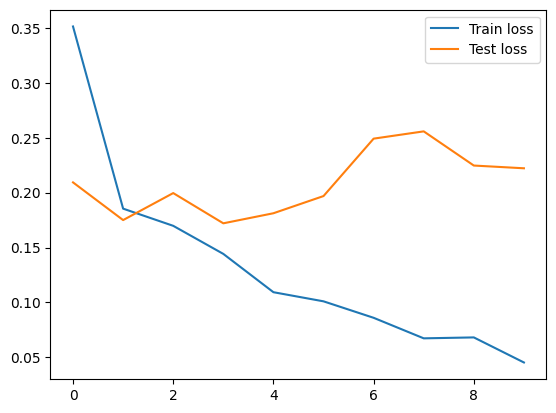

In [15]:
import matplotlib.pyplot as plt

# Examinating train and test loss

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [16]:
# Evaluating the model

model.eval()
with torch.no_grad():
    total = 0
    accurate = 0

    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device).type(torch.float32).reshape(-1, 1)
        
        # Apply the model
        y_pred = model(X)

        # Convert to 0 or 1
        predictions = (torch.sigmoid(y_pred) > 0.5).type(torch.float32)
        
        # Count corrects
        correct = (predictions == y).sum().item()
        accurate += correct
        total += y.size(0)

    accuracy = 100 * accurate / total
    print(f"Accuracy: {accuracy:.2f} %")

Accuracy: 92.45 %
